# Agent-Based Model replication
Coding bi-polarization model from Mäs & Flache (2013)

In [1]:
!pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:00


In [2]:
import mesa
import pandas as pd
import random
import statistics
from matplotlib import pyplot as plt
import numpy as np
import csv

ABM Code

This model replicates the Mäs and Flache (2013) model on opinion bipolarization. 
It only chooses one random agent per step, as only one pairwise interaction should take place per timestep t.

The model is initiated with a uniform opinion distribution. This model version is used in the paper in section 1.3.4 where a large number of simulations is run and parameter h is changed.

In [3]:
def compute_bipol(model):
    N = model.num_agents
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    
    std_opinion = statistics.stdev(agent_opinions)
    return std_opinion

def getOpinions(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    return agent_opinions
    
class OpinionAgent(mesa.Agent):
    """An agent with S arguments, an opinion and two interaction processes."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        arg_array_pro = [] # create argument vector with all P and C elements and their value of +1 and -1 
        arg_array_con = []
        for i in range(1,model.proarg+1):
            arg_array_pro.append([i,1])
            arg_array_con.append([i+model.proarg,-1])
        # shuffle each array, we will make random draws from these later, based on the opinion value selected
        arg_array_pro = random.sample(arg_array_pro, len(arg_array_pro))
        arg_array_con = random.sample(arg_array_con, len(arg_array_con))
        # we have S+1 possible opinions to draw from
        # to ensure uniform distribution of opinions at the start, we make random draws from this list
        S_plus1_lst = list(range(model.relevantArgs+1))   
        
        # make random draw from this list
        random_op_val = random.choice(S_plus1_lst)
        # make random draws from pro and con argument vectors based on this number
        # e.g., if we drew 0, we draw 0 random pro arguments and S random con arguments; and so on.
        opinion_vector_pro = random.sample(arg_array_pro, random_op_val)
        opinion_vector_con = random.sample(arg_array_con, (model.relevantArgs-random_op_val))  
        opinion_vector = opinion_vector_pro + opinion_vector_con
        
        opinion_values_vector = [arg[1] for arg in opinion_vector]
        opinion = (sum(opinion_values_vector))/model.relevantArgs # this is the agent's opinion o(i,t) that is between -1 and 1

        for i in range(len(opinion_vector)):
            opinion_vector[i].append(i+1)  # add the recency variable; we initialize this with values 1 through S
        self.opinion = opinion
        self.opinion_vector = opinion_vector
        
    def interaction(self, model): # first part of interaction is partner selection phase
     
        # first stage is partner selection
        sim_lst = [] # list of relative similarity of chosen agent i with each of the other agents created
        agent_lst = [agent for agent in model.schedule.agents if agent != self]
        for i, agent in enumerate(agent_lst):
            sim_ij = 0.5*(2-abs(self.opinion - agent.opinion))
            sim_lst.append(sim_ij)
                  
        p_lst = []
        sum_p = sum([(sim**model.homophily) for sim in sim_lst])
        for i, sim in enumerate(sim_lst):
            p = (sim**model.homophily) / sum_p
            p_lst.append(p)
        
        agent_j = random.choices(agent_lst, weights=p_lst, k=1)[0] # pick random interaction partner with weights equivalent to the probabilities based on homophily
        # make sure we don't choose the same agent for the interaction
        same_agent = False
        if agent_j == self:
            same_agent = True
            while same_agent == True:
                agent_j = random.choices(model.schedule.agents, weights=p_lst, k=1)[0]
                if agent_j == self:
                    same_agent = True
                else:
                    same_agent = False
        
        
        # second stage is interaction
        chosen_arg = self.random.choice(agent_j.opinion_vector) # the first value is the argument (either -1 or +1), while the second value indicates recency of arg for agent j, which is not interesting at this point
        
        # before we add this argument to agent i's argument vector, need to check if agent i already knows this argument
        knows_arg = False
        for i in range(len(self.opinion_vector)):
            if self.opinion_vector[i][0] == chosen_arg[0]:
                knows_arg = True
                idx_arg = i
            else:
                pass
            
        # now append if agent i does not know this argument
        if knows_arg == False:
            chosen_arg[2] = model.relevantArgs+1
            self.opinion_vector.append(chosen_arg) # append new argument with recency of S+1 to opinion vector of agent i
            for i in range(len(self.opinion_vector)):
                self.opinion_vector[i][2] = (self.opinion_vector[i][2])-1 # reduce recency of each argument by 1
            self.opinion_vector.pop(0)
        
        # only update recency of arguments if agent i already knows the argument
        if knows_arg == True:
            arg_recency = self.opinion_vector[idx_arg][2]  
            self.opinion_vector.pop(idx_arg)
            chosen_arg[2] = model.relevantArgs+1
            
            self.opinion_vector.append(chosen_arg)            
            for i in range(len(self.opinion_vector)): # now reduce recency of every argument with recency larger than communicated arg's recency
                if self.opinion_vector[i][2] > arg_recency:
                    self.opinion_vector[i][2] = (self.opinion_vector[i][2])-1
        
        # after updating agent i's opinion vector, we are updating their opinion
        self.opinion_values_vector = [arg[1] for arg in self.opinion_vector]
       
        self.opinion = (sum(self.opinion_values_vector))/model.relevantArgs
       
    
class OpinionModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, h, P, C, r):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        self.homophily = h # specify parameter h, indicating level of homophily
        self.proarg = P # number of Pro arguments
        self.conarg = C # number of Con arguments
        self.relevantArgs = r
        self.running = True

        # Create agents
        self.agent_lst = []
        
        for i in range(self.num_agents):
            a = OpinionAgent(i, self)
            self.agent_lst.append(a)
            self.schedule.add(a)
        self.datacollector = mesa.DataCollector(
            model_reporters={"Bipolarization": compute_bipol, "Opinions": getOpinions} #agent_reporters={"Opinion": "opinion"} )
        )
    def step(self):
        chosen_agent = random.choice(self.agent_lst)
        # after inspecting intermediate steps in the model, it seems that after this step.
        # for some reason, the recency values get messed up, so we fix them again here
        for i, arg in enumerate(chosen_agent.opinion_vector):
            if arg[2] != i+1:
                arg[2] = i+1
        chosen_agent.interaction(self)
        self.datacollector.collect(self)

The following code represents the replication of the paper's section 1.3.4, where the effect of homophily is analysed by only varying h and holding everything else constant. The effect is analysed in terms of share of group splits, maximum degree of bipolarization and number of timesteps needed to achieve a perfect group split.

In [4]:
# Run model
def run_model_h(homophily):
    bipolarization_lst = []
    opinions_lst = []
    for i in range(100):
        model = OpinionModel(N = 20, h = homophily, P = 20, C= 20, r = 6)
        for k in range(30000):
            model.step()
        bipolarization = model.datacollector.get_model_vars_dataframe()["Bipolarization"]
        opinions = model.datacollector.get_model_vars_dataframe()["Opinions"]
        bipolarization_lst.append(bipolarization)
        opinions_lst.append(opinions)
    return [bipolarization_lst, opinions_lst]


In [5]:
dict_bip = {}
dict_opinions = {}
for j in range(9):
    results = run_model_h(j)
    dict_bip[j] = results[0]
    dict_opinions[j] = results[1]

In [6]:
# get proportion of group splits
def share_group_splits(opinions_lst):
    final_opinions = []
    for opinions in opinions_lst:
        
        final_opinions.append(opinions[29999])
    

    group_splits = []
    for final_op_lst in final_opinions:
        if (-1.0 in final_op_lst and 1.0 in final_op_lst):
            group_splits.append(1)
        else:
            group_splits.append(0)

    share_group_split = sum(group_splits)/len(group_splits)
    return [share_group_split, group_splits]

In [7]:
share_group_splits_dict = {}
group_splits_lst = []
for key,value in dict_opinions.items():
    
    group_splits = share_group_splits(opinions_lst = value)
    share_group_splits_dict[key] = group_splits[0]
    group_splits_lst.append(group_splits[1])

In [8]:
# get number of timesteps needed to achieve perfect group split
def get_timesteps(opinions_lst, group_splits):
    time_of_split_lst = []
    for i, opinions in enumerate(opinions_lst):
        if group_splits[i] == 1: # if 1, then we have a group split; we only consider these cases
            for idx, j in enumerate(opinions):
                perfect_split = []
                for opinion in j:
                    if opinion == 1.0 or opinion == -1.0:
                        perfect_split.append(True)
                    else:
                        perfect_split.append(False)
                if False not in perfect_split:
                    
                    time_of_split_lst.append(idx)
                    break
    try:
        avg_time_of_split = sum(time_of_split_lst)/len(time_of_split_lst)
    except:
        avg_time_of_split = 0
    return avg_time_of_split 

In [9]:
avg_time_of_split = {}
i = 0
for key, value in dict_opinions.items():
    timesteps = get_timesteps(value, group_splits_lst[i])
    avg_time_of_split[key] = timesteps
    i+=1

In [10]:
# intensity of bipolarization for each value of h
def get_bip_intensity(bipolarization_lst):
    max_bip_lst = []
    initial_bip_lst = []
    for simulation in bipolarization_lst:
        max_bip = max(simulation)
        max_bip_lst.append(max_bip)
        initial_bip_lst.append(simulation[0])
    
    max_avg_bip = sum(max_bip_lst)/len(max_bip_lst)
    initial_avg_bip = sum(initial_bip_lst)/len(initial_bip_lst)
    return [max_avg_bip, initial_avg_bip]

In [11]:
bip_intensity = {}
for key, value in dict_bip.items():
    bip_intensity_val = get_bip_intensity(value)
    bip_intensity[key] = bip_intensity_val

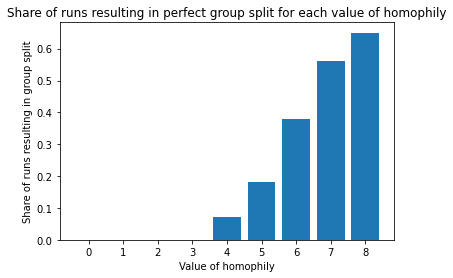

In [12]:
# vizualize share of group splits

names = list(share_group_splits_dict.keys())
values = list(share_group_splits_dict.values())

plt.bar(range(len(share_group_splits_dict)), values, tick_label=names)
plt.ylabel('Share of runs resulting in group split')
plt.xlabel('Value of homophily')
plt.title('Share of runs resulting in perfect group split for each value of homophily')

plt.show()

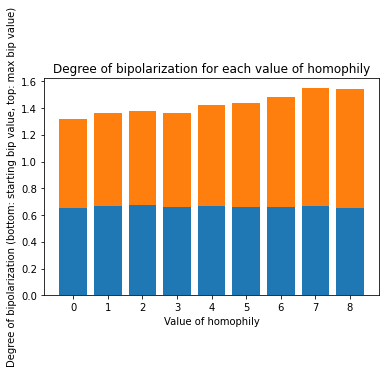

In [13]:
# visualize degree of bipolarization

N = 9
ind = np.arange(N)    # the x locations for the groups

bip_int_lst = list(bip_intensity.values())
values_start_bip = [bip[1] for bip in bip_int_lst]
values_max_bip = [bip[0] for bip in bip_int_lst]

p1 = plt.bar(ind, values_start_bip)
p2 = plt.bar(ind, values_max_bip,
             bottom=values_start_bip)

names = list(bip_intensity.keys())
plt.ylabel('Degree of bipolarization (bottom: starting bip value, top: max bip value)')
plt.xlabel('Value of homophily')
plt.title('Degree of bipolarization for each value of homophily')

plt.xticks(ind, names)


plt.show()

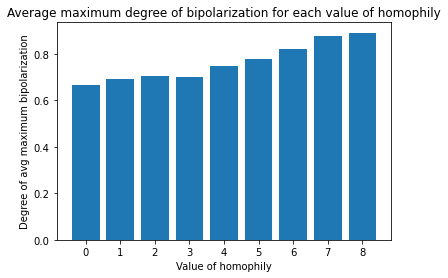

In [14]:
# visualize degree of bipolarization 2

names = list(share_group_splits_dict.keys())
values = [bip[0] for bip in bip_int_lst]

plt.bar(range(len(share_group_splits_dict)), values, tick_label=names)
plt.ylabel('Degree of avg maximum bipolarization')
plt.xlabel('Value of homophily')
plt.title('Average maximum degree of bipolarization for each value of homophily')

plt.show()

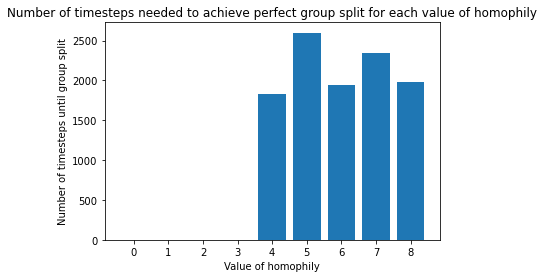

In [15]:
# visualize number of timesteps needed to achieve group split

names = list(avg_time_of_split.keys())
values = list(avg_time_of_split.values())

plt.bar(range(len(avg_time_of_split)), values, tick_label=names)
plt.ylabel('Number of timesteps until group split')
plt.xlabel('Value of homophily')
plt.title('Number of timesteps needed to achieve perfect group split for each value of homophily')

plt.show()